In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/currgames2/currgames.csv
/kaggle/input/currgames3/currgames.csv
/kaggle/input/currgames/currgames.csv
/kaggle/input/nba-games/players.csv
/kaggle/input/nba-games/teams.csv
/kaggle/input/nba-games/ranking.csv
/kaggle/input/nba-games/games_details.csv
/kaggle/input/nba-games/games.csv


In [2]:
#import requests

#jsonData = requests.get('https://data.nba.net/prod/v2/20200224/scoreboard.json').json()

#for each in jsonData['games']:
    #print ('%s @ %s' %(each['vTeam']['triCode'], each['hTeam']['triCode']))

# NBA Predictions

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/NBA-Predictions/NBA-Analysis/blob/main/Random%20Forest.ipynb)

## Initial analysis of relevant data

Before we begin to code our ML model we must first look into what data is not only relevant to what it is we are trying to accomplish but if the data is related to the desired outcome. In this particular case we can define our desired outcome as;

    -Predict the outcome of NBA games

Though vague it is important to have an understanding of the ultimate goal. With that in mind we must determine what is considered relevant to being able to make these predictions. For the purposes of this analysis we will look at what data appears to relate to winning a game to have a more concrete idea of what features to include in the model.

First we will load the data into a pandas dataframes and take a look at the data, more specifically we will first look into the games.csv for our initial dive into the data. This is because the games.csv has final game data and we can begin with simple probing into the data itself. Later we will look into as much of the data as we can.

In [3]:
gameData = pd.read_csv("/kaggle/input/nba-games/games_details.csv")
games = pd.read_csv("/kaggle/input/nba-games/games.csv")
players = pd.read_csv("/kaggle/input/nba-games/players.csv")
teams = pd.read_csv("/kaggle/input/nba-games/teams.csv")
rankings = pd.read_csv("/kaggle/input/nba-games/ranking.csv")
today = pd.read_csv("/kaggle/input/currgames3/currgames.csv")
#initial dataframes for all .csv files
#For now the only dataframe we will look into is games
games.head()
today.head()

/tmp/ipykernel_18/2187376201.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  gameData = pd.read_csv("/kaggle/input/nba-games/games_details.csv")


,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,AST_home,REB_home,HOME_TEAM_ID
0,1610612748,110,0.46,0.81,28,37,Heat
1,1610612740,115,0.48,0.77,27,44,Pelicans
2,1610612743,115,0.50,0.76,30,44,Nuggets


In [4]:
games.shape

(26651, 21)

# Home Team advantage

Generally the team who is playing the home game is considered to have the advantage. We will do a small dive into this and see how true this claim is by looking at the data.

/tmp/ipykernel_18/934583140.py:4: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  home_wins = home_team_group.get_group(1)
/tmp/ipykernel_18/934583140.py:5: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  home_loses = home_team_group.get_group(0)


Home team win percentage: 58.70% 
Away team win percentage: 41.30%


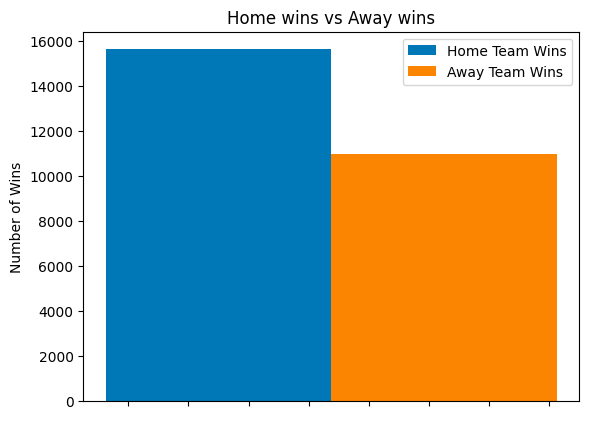

In [5]:
import matplotlib.pyplot as plt

home_team_group = games.groupby(["HOME_TEAM_WINS"])
home_wins = home_team_group.get_group(1)
home_loses = home_team_group.get_group(0)

home_team_wins = home_wins["HOME_TEAM_WINS"].value_counts()
away_team_wins = home_loses["HOME_TEAM_WINS"].value_counts()

plt.bar(0.5, home_team_wins, width = .75,color = '#0077b6',label = 'Home Team Wins')
plt.bar(1.25, away_team_wins, width = .75,color = '#fb8500',label = 'Away Team Wins')

plt.ylabel('Number of Wins')
plt.xticks(color = 'w')
plt.title('Home wins vs Away wins')
plt.legend()

percentage_for_home = games['HOME_TEAM_WINS'].value_counts()/len(games) * 100
print(f'Home team win percentage: {percentage_for_home[1]:.2f}% \nAway team win percentage: {percentage_for_home[0]:.2f}%')

# Home Game Results

The data shows that home teams will win 58.7% of the time while the away teams will win 41.3% of the time. This does show some kind of relation to winning a game and playing at home court. However, there are a couple of factors that are not taken into account;


1) The data does not represent a single team

2) The results do not tell us why this appears to be the case

3) There is no information on what factors are in play that result in these cases


Though there certainly could be some factors that play into these results it does show a potential data point for the ML model that we will implement at a later time. For now we can follow our current investigation via home team wins vs away team wins by looking into the differences between average point differences.

(15645, 21)


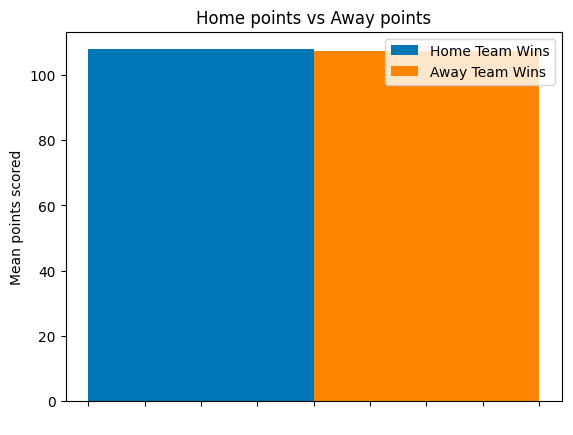

In [6]:
home_pts = home_wins["PTS_home"].mean()
away_pts = home_loses["PTS_away"].mean()

print(home_wins.shape)

plt.bar(.25, home_pts, width = 0.01,color = '#0077b6',label = 'Home Team Wins')
plt.bar(.26, away_pts, width = 0.01,color = '#fb8500',label = 'Away Team Wins')

plt.ylabel('Mean points scored')
plt.xticks(color = 'w')
plt.title('Home points vs Away points')
plt.legend()

# Mean points scored

Though slight we can see that home teams every so slightly score more points on average. This data is most likely not usable for the ML model, not because it does not give insight, but because the difference between the two is not informative enough of what is occuring. Instead we should try and find the average score of individual teams and use this data as it would be more accurate to an individual teams standing. That having been said though only slight this data does match to some extent what we are looking for, though once again, there are issues with this as well.


# Recomendation

Though there is still a great deal of information to be gathered from the dataset I think this is a good place to start working on a simple ML model that will take in the team names and make a prediction based on number of games won alone, then work in new features from there. This is also a good place to work on building Elo rankings for simple predictions that do not involve ML which can take a considerable amount of time to make. This will also have the effect of potentially including the liklihood of winning a home game as well.

For now we can start sorting and looking into the relevant data.

In [7]:
games = games.sort_values(by='GAME_DATE_EST').reset_index(drop = True)
#sort the array by date in ascending order
games.isnull().values.any()
#check for any null/NaN/NaT values in the dataframe

True

As shown above we do have null values which are not useful to us. Therefore we will drop them.

In [8]:
games = games.dropna()
#drop all null/NaN/Nat values from the dataframe
print(games.isnull().values.any())
print(games.shape)
#print the results to make sure we dropped the desired values
games.head()
#check the first few entries of the newly arranged dataframe

False
(26552, 21)


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2003-10-05,10300001,Final,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,...,23.0,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1
1,2003-10-06,10300002,Final,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,...,25.0,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1
2,2003-10-07,10300010,Final,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,...,26.0,45.0,1610612752,86.0,0.380,0.852,0.188,19.0,37.0,1
3,2003-10-07,10300009,Final,1610612758,1610612746,2003,1610612758,101.0,0.467,0.871,...,19.0,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1
4,2003-10-07,10300005,Final,1610612757,1610612745,2003,1610612757,104.0,0.527,0.657,...,22.0,33.0,1610612745,80.0,0.470,0.667,0.333,10.0,37.0,1


Now that we have no NaN values in our dataset we can begin the process of determining the average points scored for all teams. This will involve a little data manipulation on our end, and we will need to create new data frames that are copies of the originals to preserve the integrity of the original files we will be using in the instance that we need that preserved data later on.

In [9]:
# We have two columns to replace, there are 'HOME_TEAM_ID' and 'VISITOR_TEAM_ID'

teams = teams[['TEAM_ID', 'NICKNAME']]

# replace 'HOME_TEAM_ID' with names in df_names
home_names = teams.copy() # copy the names data
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_1 = pd.merge(games['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
games['HOME_TEAM_ID'] = result_1['NICKNAME']

# replace 'VISITOR_TEAM_ID' with names in df_names
visitor_names = teams.copy() # copy the names data
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_2 = pd.merge(games['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
games['VISITOR_TEAM_ID'] = result_2['NICKNAME']

In [10]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2003-10-05,10300001,Final,Jazz,Mavericks,2003,1610612762,90.0,0.457,0.735,...,23.0,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1
1,2003-10-06,10300002,Final,Grizzlies,Bucks,2003,1610612763,105.0,0.494,0.618,...,25.0,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1
2,2003-10-07,10300010,Final,Wizards,Knicks,2003,1610612764,104.0,0.506,0.677,...,26.0,45.0,1610612752,86.0,0.380,0.852,0.188,19.0,37.0,1
3,2003-10-07,10300009,Final,Kings,Clippers,2003,1610612758,101.0,0.467,0.871,...,19.0,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1
4,2003-10-07,10300005,Final,Trail Blazers,Rockets,2003,1610612757,104.0,0.527,0.657,...,22.0,33.0,1610612745,80.0,0.470,0.667,0.333,10.0,37.0,1


We have successfully changed the HOME_TEAM_ID and VISITOR_TEAM_ID collumns to represent the names of the teams in a more easily understandable way, more specificially we replaced the team id numbers and switched them with the actual team names so we know what teams we are working with.

Next we will create an increadibly basic ML model to make predictions with. This will not be accurate or representative of anything, and the predictions will likely be flawed and useless. However, for the purposes of creating an output file that can be grabbed by the website it will work for our purposes.

In [11]:
# we want to predict games after the 2020-2021 season so we will drop these data from our dataframe
# later we will grab use that dropped data for making predictions on.

games = games.loc[games['GAME_DATE_EST'] < '2020-08-01'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split
#below we have our features in X and the outcomes in y, this will be split into
# training and validation data
X = games[['TEAM_ID_home', 'PTS_home', 'FG_PCT_home','FT_PCT_home', 'AST_home', 'REB_home']].copy()
y = games['HOME_TEAM_WINS'].copy()

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# below our data is fit into vectors which is the actual data that our ML model
# can use
#tfidf_vectorizer = TfidfVectorizer()
#X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()

print(f"X_train.shape = {X_train_raw.shape}")
type(X_train_raw)

X_train.shape = (18566, 6)


pandas.core.frame.DataFrame

accuracy (on y_train): 0.9999


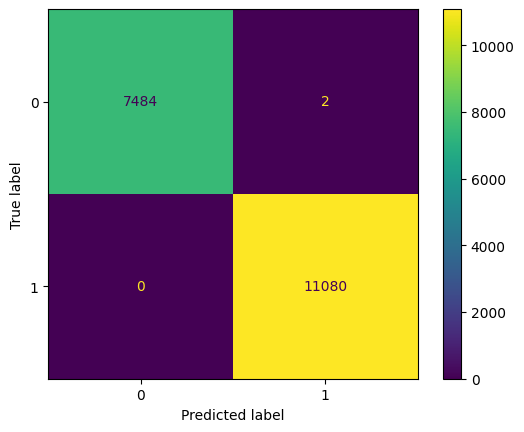

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Initilazation of the RandomForestClassifier ML model and fitting of the data to the model
model = RandomForestClassifier()
model = model.fit(X_train_raw, y_train)

#Predictions the model has made
predictions_train = model.predict(X_train_raw)

#confusion matrix to show the accuracy of the model on the training data
#note: the model has not yet been validated
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train), display_labels=['0', '1'])
disp.plot()
print(f"accuracy (on y_train): {accuracy_score(y_train, predictions_train):.4f}")

# Results of training dummy model

As shown above this model is just guessing, the accuracy score is not a true representation of any game being played, but for the purposes of setting up this is fine, we will go back and adjust things so that we can get actual predictions. This is likely because every team has a roughly 60% chance of winning therefor the model simply guesses that the team put in will win. Though this is just the training because it only guessed wins we can assume that this trend will continue in the validation data as well. As such we should see a similar distribution of predictions.

# Interesting observation

Many professional ML models in the same space are roughly 70% accurate. It is possible that a significant percentage of this may be from home court advantage, though certainly not the 59% above. As features are added we will need to see how much the data strays from the original test and validations.

In [15]:
#vectorize validation data
#X_val = tfidf_vectorizer.transform(X_val_raw).toarray()
print(f"X_val.shape = {X_val_raw.shape}")
type(X_val_raw)

X_val.shape = (4642, 6)


pandas.core.frame.DataFrame

accuracy (on y_val): 0.7439


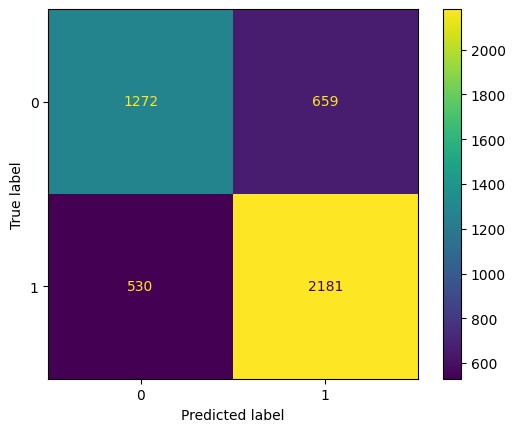

In [16]:

#Validate the model
predictions_val = model.predict(X_val_raw)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['0', '1'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y_val, predictions_val):.4f}")

# Results of validation

The results of the validation are exactly what is expected, and that is only guessing that the outcomes of the game will be a victory for the home team. This is once again entirely expected and ensures that we know what is occuring and why. Again this data is useless for a true final model.

In [17]:
#create test data, this will output the results into another file
df_test = games.loc[games['GAME_DATE_EST'] > '2019-10-01'].reset_index(drop=True)
df_pred = today

In [18]:
#vectorize the test data into something that the trained ML model can use
X_test = df_test[['TEAM_ID_home', 'PTS_home', 'FG_PCT_home','FT_PCT_home','AST_home', 'REB_home']]
X_pred = df_pred[['TEAM_ID_home', 'PTS_home', 'FG_PCT_home','FT_PCT_home','AST_home', 'REB_home']]
print(f"X_test.shape = {X_test.shape}")
type(X_test)

X_test.shape = (1077, 6)


pandas.core.frame.DataFrame

In [19]:


# refit the model with the best hyperparameter value we found
model = RandomForestClassifier(max_leaf_nodes = 34)
model = model.fit(X_train_raw, y_train)

# this make predictions for the test set
predictions_test = model.predict(X_test)
predictions_test[:10]

predictions = model.predict(X_pred)
predictions



array([0, 1, 1])

In [20]:
df_test['predictions'] = predictions_test
pd.set_option("display.max_colwidth", 240)
df_test.head(n=10)
df_pred['predictions'] = predictions

In [21]:
df_submission = df_pred[['HOME_TEAM_ID','predictions']]
df_submission.columns = ['HOME_TEAM_ID', 'predictions']
df_submission.head()

,HOME_TEAM_ID,predictions
0,Heat,0
1,Pelicans,1
2,Nuggets,1


In [22]:
df_submission.to_csv('dummyResults.csv', index=False)